In [124]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#just for the notebook
%run implementations
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [125]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)


In [126]:
tX

array([[ 138.47 ,   51.655,   97.827, ...,    1.24 ,   -2.475,  113.497],
       [ 160.937,   68.768,  103.235, ..., -999.   , -999.   ,   46.226],
       [-999.   ,  162.172,  125.953, ..., -999.   , -999.   ,   44.251],
       ...,
       [ 105.457,   60.526,   75.839, ..., -999.   , -999.   ,   41.992],
       [  94.951,   19.362,   68.812, ..., -999.   , -999.   ,    0.   ],
       [-999.   ,   72.756,   70.831, ..., -999.   , -999.   ,    0.   ]])

In [127]:
tX

array([[ 138.47 ,   51.655,   97.827, ...,    1.24 ,   -2.475,  113.497],
       [ 160.937,   68.768,  103.235, ..., -999.   , -999.   ,   46.226],
       [-999.   ,  162.172,  125.953, ..., -999.   , -999.   ,   44.251],
       ...,
       [ 105.457,   60.526,   75.839, ..., -999.   , -999.   ,   41.992],
       [  94.951,   19.362,   68.812, ..., -999.   , -999.   ,    0.   ],
       [-999.   ,   72.756,   70.831, ..., -999.   , -999.   ,    0.   ]])

In [128]:
#replace -999 with nan
tX = replace_999_with_nan(tX)
tX

array([[138.47 ,  51.655,  97.827, ...,   1.24 ,  -2.475, 113.497],
       [160.937,  68.768, 103.235, ...,     nan,     nan,  46.226],
       [    nan, 162.172, 125.953, ...,     nan,     nan,  44.251],
       ...,
       [105.457,  60.526,  75.839, ...,     nan,     nan,  41.992],
       [ 94.951,  19.362,  68.812, ...,     nan,     nan,   0.   ],
       [    nan,  72.756,  70.831, ...,     nan,     nan,   0.   ]])

In [129]:
#substract mean and divide by std, replace Nans with mean
tX = normalize(tX)

In [130]:
#Split data according to ration
x_train, y_train, x_test, y_test = split_data(tX, y, 0.8, seed=1)

In [131]:
#Make sure there is no nans
np.isnan(tX).any()

False

In [132]:
# Append y values as column to later divide y into buckets corresponding with x values
train = np.column_stack((x_train, y_train))

In [133]:
# Split training x into buckets
buckets = get_buckets(train)

In [134]:
initial_weights = np.zeros(x_train.shape[1])

In [135]:
from implementations import ridge_regression
# Least squares
#w , loss = least_squares(y_train,x_train)

# Least squares GD
#w , loss = least_squares_GD(y_train,x_train,initial_weights,200,0.01)

# Least squares SGD
#w, loss = least_squares_SGD(y_train,x_train,initial_weights,200,0.01)

# Ridge regression
w,loss = ridge_regression(y_train,x_train,0.0001)

# Logistic regression
#w,loss = logistic_regression(y_train,x_train,initial_weights,400,0.0001)

# reg logistic regression
#w,loss = reg_logistic_regression(y_train,x_train,0.001,initial_weights,100,0.0001)

In [136]:
w

array([ 1.80848312e-02, -2.49250139e-01, -2.59649908e-01,  3.39068041e-02,
        3.21115481e-02,  2.50253502e-01,  3.61473647e-02,  2.74732434e-01,
       -3.99510317e-02, -1.46193202e+01, -1.86328843e-01,  1.25672018e-01,
        1.24077113e-01,  3.01051373e+00,  2.15686335e-04, -1.21489760e-03,
        3.06761247e+00, -6.39789968e-04,  2.86354808e-03,  9.30357882e-02,
        3.49378807e-04, -4.27363662e-02, -3.41691550e-01, -4.31452996e-01,
       -4.67750255e-04,  4.47019613e-04, -2.56593624e-01,  3.43277086e-03,
       -3.82909553e-03,  1.29493347e+01])

## Do your thing crazy machine learning thing here :) ...

## Generate predictions and save ouput in csv format for submission:

In [103]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [114]:
weights = w
weights.shape

(30,)

In [115]:
OUTPUT_PATH = '../data/sub.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

# Computing score on validation set

In [137]:
weights = w
y_pred = predict_labels(weights,x_test)

In [138]:
w

array([ 1.80848312e-02, -2.49250139e-01, -2.59649908e-01,  3.39068041e-02,
        3.21115481e-02,  2.50253502e-01,  3.61473647e-02,  2.74732434e-01,
       -3.99510317e-02, -1.46193202e+01, -1.86328843e-01,  1.25672018e-01,
        1.24077113e-01,  3.01051373e+00,  2.15686335e-04, -1.21489760e-03,
        3.06761247e+00, -6.39789968e-04,  2.86354808e-03,  9.30357882e-02,
        3.49378807e-04, -4.27363662e-02, -3.41691550e-01, -4.31452996e-01,
       -4.67750255e-04,  4.47019613e-04, -2.56593624e-01,  3.43277086e-03,
       -3.82909553e-03,  1.29493347e+01])

In [139]:
# Compute accuracy 
true_positive = 0
false_positive = 0 
true_negative = 0
false_negative = 0

testing_length = y_test.shape[0]
for i in range(testing_length):      
    if (y_test[i] == y_pred[i]) and (y_pred[i]==1):        
        true_positive += 1
    if (y_test[i] == y_pred[i]) and (y_pred[i]==-1):
        true_negative +=1        
    if (y_test[i] != y_pred[i]) and (y_pred[i]==-1):    
        false_negative += 1
    if (y_test[i] != y_pred[i]) and (y_pred[i]==1):
        false_positive +=1
        
        
precision = true_positive/float(true_positive+false_positive)
recall =true_positive/float(true_positive + false_negative)
F=2 *(precision*recall)/float(precision+recall)        
    

print('Train accuracy: ',  ((true_positive+true_negative)/float(testing_length))*100.0)
print("precision : ", precision)
print("recall : ",recall)
print("F1 score : ",F)

        

Train accuracy:  74.506
precision :  0.6651440359537317
recall :  0.5239698200812536
F1 score :  0.5861766711034638


In [140]:
def cross_validation_visualization(lambds, mse_tr, mse_te):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validation")

In [141]:
def cross_validation_demo():
    seed = 12
    degree = 1
    k_fold = 5
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    # cross validation
    for lambda_ in lambdas:
        print("lambda",lambda_)
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            loss_tr, loss_te,_ = cross_validation(y, tX, k_indices, k, lambda_, degree)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
        rmse_tr.append(np.mean(rmse_tr_tmp))
        rmse_te.append(np.mean(rmse_te_tmp))

    cross_validation_visualization(lambdas, rmse_tr, rmse_te)


lambda 0.0001
lambda 0.00013738237958832623
lambda 0.00018873918221350977
lambda 0.0002592943797404667
lambda 0.0003562247890262444
lambda 0.0004893900918477494
lambda 0.0006723357536499335
lambda 0.0009236708571873865
lambda 0.0012689610031679222
lambda 0.0017433288221999873
lambda 0.002395026619987486
lambda 0.0032903445623126675
lambda 0.004520353656360241
lambda 0.006210169418915616
lambda 0.008531678524172805
lambda 0.011721022975334805
lambda 0.01610262027560939
lambda 0.02212216291070448
lambda 0.03039195382313198
lambda 0.041753189365604
lambda 0.05736152510448681
lambda 0.07880462815669913
lambda 0.1082636733874054
lambda 0.14873521072935117
lambda 0.20433597178569418
lambda 0.2807216203941176
lambda 0.38566204211634725
lambda 0.5298316906283708
lambda 0.7278953843983146
lambda 1.0


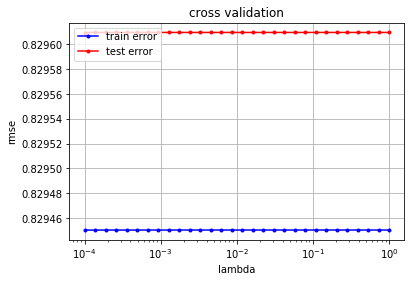

In [142]:
cross_validation_demo()